In [423]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from math import gamma
from TLPP_Generation import Logic_Model_Generator
from tqdm import *

class LSTM_Encoding_Action(nn.Module):

    '''
    input: [batch_size, num_predicate, seq_length]
    Parameters:
        input_size:
        hidden_size:
        output_size:
        num_layers:
    '''

    def __init__(self, input_size, hidden_size, output_size, batch_size, device, num_layers:int = 1) -> None:
        super().__init__()

        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # one-directional LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x:torch.tensor):
        batch_size, num_predicate, seq_length = x.shape
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        x, _  = self.lstm(x, (h_0, c_0)) #NOTE: x:(batch_size, seq_length, num_directions * hidden_size)
        x = self.linear(x)
        x = x.view(batch_size, num_predicate, -1)
        return x


class LSTM_Encoding_History(nn.Module):

    '''
    NOTE:Returns a categorical distribution

    Parameters:
        input_size:
        hidden_size:
        output_size:
        num_layers
    '''

    def __init__(self, input_size, hidden_size, output_size, batch_size, device, num_layers: int = 1) -> None:
        super().__init__()

        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # one-directional LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x:torch.tensor, action_embedding: torch.tensor):
        '''
        Parameters:
            x: mental history
            action_embedding: encoding of action history. This should be the output of LSTM_Encoding_Action
        '''
        batch_size, num_predicate, seq_length = x.shape
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        x, _ = self.lstm(x,(h_0,c_0))                              #NOTE: x:(batch_size, seq_length, num_directions * hidden_size)
        x = torch.concat(tensors=[x, action_embedding], dim=1)     #NOTE: concatenate the action info and the mental info
        batch_size, num_predicate, hidden_size = x.shape           #NOTE: num_predicate is changed
        x = self.linear(x)                                         #NOTE: x:(batch_size, seq_length, num_directions * output_size)
        x = x.view(batch_size, num_predicate, -1)
        #TODO: return a vector with dimension (I+1), (I represents the number of types of mental states)
        #TODO: the i-th (i=0,1,2,...,I) component of the output x represents the probability of the i-th mental type
        x = self.softmax(x)
        return x.view(-1,self.output_size).mean(axis=0)
        

class Logic_Model_Incomplete_Data:

    def __init__(self, time_horizon:float, action_history:dict, hidden_size:tuple, output_size:tuple, batch_size:int, partition_size:float=0.1, device:str='cuda') -> None:
        self.time_horizon = time_horizon
        self.partition_size = partition_size            # num of small time intervals
        self.action_history = action_history
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = device
        #TODO:
        ### the following parameters are used to manually define the logic rules
        self.num_predicate = 7                  # num_predicate is same as num_node
        self.num_formula = 8                    # num of prespecified logic rules
        self.BEFORE = 'BEFORE'
        self.EQUAL = 'EQUAL'
        self.AFTER = 'AFTER'
        self.Time_tolerance = 0.3               
        self.body_predicate_set = []                        # the index set of all body predicates
        self.mental_predicate_set = [0, 1, 2]
        self.action_predicate_set = [3, 4, 5, 6]
        self.head_predicate_set = [0, 1, 2, 3, 4, 5, 6]     # the index set of all head predicates
        self.decay_rate = 1                                 # decay kernel
        self.integral_resolution = 0.03

        #TODO: convert the action_history:dict to a numpy array 'processed_data':np.array to put in the LSTMs
        self.processed_data = self.process_data(action_history=self.action_history).to(device)
        self.INPUT_SIZE_A = self.processed_data.shape[-1]
        self.INPUT_SIZE_M = int(self.time_horizon / self.partition_size)

        #TODO: construct two LSTMs to encode the past history
        #NOTE: encoding action history
        self.LSTM_Action = LSTM_Encoding_Action(input_size=self.INPUT_SIZE_A,hidden_size=hidden_size[0],output_size=output_size[0],batch_size=batch_size,device=device)
        self.LSTM_Action.to(device)
        #NOTE: encoding whole history
        self.LSTM_History = LSTM_Encoding_History(input_size=self.INPUT_SIZE_M,hidden_size=hidden_size[1],output_size=output_size[1],batch_size=batch_size ,device=device)
        self.LSTM_History.to(device)


        ### the following parameters are used to generate synthetic data
        ### for the learning part, the following is used to claim variables
        ### self.model_parameter = {0:{},1:{},...,6:{}}
        self.model_parameter = {}


        '''
        mental
        '''

        head_predicate_idx = 0
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.3).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)
        formula_idx = 1
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 1
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.3).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.02).double(), requires_grad=True)
        formula_idx = 1
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 2
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.2).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.1).double(), requires_grad=True)


        '''
        action
        '''
        head_predicate_idx = 3
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.1).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 4
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.25).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.05).double(), requires_grad=True)

        head_predicate_idx = 5
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.6).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.8).double(), requires_grad=True)

        head_predicate_idx = 6
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.1).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.05).double(), requires_grad=True)




        #NOTE: set the content of logic rules
        self.logic_template = self.logic_rule()
    
    def logic_rule(self):
        #TODO: the logic rules encode the prior knowledge
        # encode rule information
        '''
        This function encodes the content of logic rules
        logic_template = {0:{},1:{},...,6:{}}
        '''
        logic_template = {}


        '''
        Mental (0-2)
        '''

        head_predicate_idx = 0
        logic_template[head_predicate_idx] = {} # here 0 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (2 and 3 and 4) and before(2,0) and before(3,0) and before(4,0) \to 0
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [2,3,4]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1, 1]  # use 1 to indicate True; use -1 to indicate False
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[2, 0], [3, 0], [4, 0]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE, self.BEFORE]


        #NOTE: rule content: ((\neg 0 and (2 and 6)) and after(6,0) and equal(2,0) \to \neg 0)
        formula_idx = 1
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 2, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [-1, 1, 1]  # use 1 to indicate True; use -1 to indicate False
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[6, 0], [2, 0]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.AFTER, self.EQUAL]

        head_predicate_idx = 1
        logic_template[head_predicate_idx] = {}  # here 1 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: 5 and before(5,1) to 1
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [5]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[5, 1]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]

        #NOTE: rule content: (4 and 6) and before(6,1) to \neg 1
        formula_idx = 1
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [4, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[6, 1]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]


        head_predicate_idx = 2
        logic_template[head_predicate_idx] = {}  # here 2 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (\neg 1 and 6) and after(1,2) to 2
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [-1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 2]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.AFTER]



        '''
        Action (3-6)
        '''
        head_predicate_idx = 3
        logic_template[head_predicate_idx] = {}  # here 3 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (0 and \neg 1) and before(0,1) and before(1,3) \to 3
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, -1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 1], [1, 3]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        head_predicate_idx = 4
        logic_template[head_predicate_idx] = {}  # here 4 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (2) and before(2,4) \to 4
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [2]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[2, 4]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]

        
        head_predicate_idx = 5
        logic_template[head_predicate_idx] = {}  # here 5 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (0 and \neg 1) and before(0,5) and after(1,5) \to 5
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, -1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 5], [1, 5]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.AFTER]


        head_predicate_idx = 6
        logic_template[head_predicate_idx] = {}  # here 6 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (1 and 2) and before(1,6) and before(2,6) \to \neg 6
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1, 2]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 6], [2, 6]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        return logic_template

    def intensity(self, cur_time, head_predicate_idx, history)->torch.tensor:
        feature_formula = []
        weight_formula = []
        effect_formula = []
        #TODO: Check if the head_prediate is a mental predicate
        if head_predicate_idx in self.mental_predicate_set: flag = 0
        else: flag = 1  #NOTE: action

        for formula_idx in list(self.logic_template[head_predicate_idx].keys()):
            weight_formula.append(self.model_parameter[head_predicate_idx][formula_idx]['weight'])

            feature_formula.append(self.get_feature(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                    history=history, template=self.logic_template[head_predicate_idx][formula_idx], flag=flag))
            effect_formula.append(self.get_formula_effect(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                       history=history, template=self.logic_template[head_predicate_idx][formula_idx]))
        intensity = torch.exp(torch.cat(weight_formula, dim=0))/torch.sum(torch.exp(torch.cat(weight_formula, dim=0)), dim=0) * torch.cat(feature_formula, dim=0) * torch.cat(effect_formula, dim=0)
        intensity = self.model_parameter[head_predicate_idx]['base'] + torch.sum(intensity)
        intensity = torch.exp(intensity)

        return intensity

    def get_feature(self, cur_time, head_predicate_idx, history, template, flag:int):
        #NOTE: flag: 0 or 1, denotes the head_predicate_idx is a mental or an action
        #NOTE: 0 for mental and 1 for action
        #NOTE: since for mental, we need to go through all the history information
        #NOTE: while for action, we only care about the current time information
        
        transition_time_dic = {}
        feature = torch.tensor([0], dtype=torch.float64)
        for idx, body_predicate_idx in enumerate(template['body_predicate_idx']):
            transition_time = np.array(history[body_predicate_idx]['time'])
            transition_state = np.array(history[body_predicate_idx]['state'])
            mask = (transition_time <= cur_time) * (transition_state == template['body_predicate_sign'][idx])
            transition_time_dic[body_predicate_idx] = transition_time[mask]
        transition_time_dic[head_predicate_idx] = [cur_time]
        ### get weights
        # compute features whenever any item of the transition_item_dic is nonempty
        history_transition_len = [len(i) for i in transition_time_dic.values()]
        if min(history_transition_len) > 0:
            # need to compute feature using logic rules
            time_combination = np.array(list(itertools.product(*transition_time_dic.values())))
            time_combination_dic = {}
            for i, idx in enumerate(list(transition_time_dic.keys())):
                #TODO: this is where we distinguish mental and action
                time_combination_dic[idx] = time_combination[:, i] if flag == 0 else time_combination[-1, i]
            temporal_kernel = np.ones(len(time_combination))
            for idx, temporal_relation_idx in enumerate(template['temporal_relation_idx']):       
                #TODO: checkpoint
                #print('head_predicate_idx: {}; temporal_relation_idx[0]: {}, temporal_relation_idx[1]: {}'.format(head_predicate_idx, temporal_relation_idx[0], temporal_relation_idx[1]))
                #print('temporal combination dict: {}'.format(time_combination_dic))
         
                time_difference = time_combination_dic[temporal_relation_idx[0]] - time_combination_dic[temporal_relation_idx[1]]
                if template['temporal_relation_type'][idx] == 'BEFORE':
                    temporal_kernel *= (time_difference < - self.Time_tolerance) * np.exp(-self.decay_rate *(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'EQUAL':
                    temporal_kernel *= (abs(time_difference) <= self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'AFTER':
                    temporal_kernel *= (time_difference > self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[1]]))
            feature = torch.tensor([np.sum(temporal_kernel)], dtype=torch.float64)
        return feature

    def get_formula_effect(self, cur_time, head_predicate_idx, history, template):
        ## Note this part is very important!! For generator, this should be np.sum(cur_time > head_transition_time) - 1
        ## Since at the transition times, choose the intensity function right before the transition time
        head_transition_time = np.array(history[head_predicate_idx]['time'])
        head_transition_state = np.array(history[head_predicate_idx]['state'])
        if len(head_transition_time) == 0:
            cur_state = 0
            counter_state = 1 - cur_state
        else:
            idx = np.sum(cur_time > head_transition_time) - 1
            cur_state = head_transition_state[idx]
            counter_state = 1 - cur_state
        if counter_state == template['head_predicate_sign']:
            formula_effect = torch.tensor([1], dtype=torch.float64)
        else:
            formula_effect = torch.tensor([-1], dtype=torch.float64)
        return formula_effect

    def log_likelihood(self, dataset, sample_ID_batch, T_max)->torch.tensor:
        '''
        This function calculates the log-likehood given the dataset
        log-likelihood = \sum log(intensity(transition_time)) + int_0^T intensity dt

        Parameters:
            dataset: 
            sample_ID_batch: list
            T_max:
        '''
        log_likelihood = torch.tensor([0], dtype=torch.float64)
        # iterate over samples
        for sample_ID in sample_ID_batch:
            # iterate over head predicates; each predicate corresponds to one intensity
            data_sample = dataset[sample_ID]
            for head_predicate_idx in self.head_predicate_set:
                #NOTE: compute the summation of log intensities at the transition times
                intensity_log_sum = self.intensity_log_sum(head_predicate_idx, data_sample)
                #NOTE: compute the integration of intensity function over the time horizon
                intensity_integral = self.intensity_integral(head_predicate_idx, data_sample, T_max)
                log_likelihood += (intensity_log_sum - intensity_integral)
        return log_likelihood

    def intensity_log_sum(self, head_predicate_idx, data_sample):
        intensity_transition = []
        for t in data_sample[head_predicate_idx]['time'][1:]:
            #NOTE: compute the intensity at transition times
            cur_intensity:torch.tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_transition.append(cur_intensity)
        if len(intensity_transition) == 0: # only survival term, no event happens
            log_sum = torch.tensor([0], dtype=torch.float64)
        else:
            log_sum = torch.sum(torch.log(torch.cat(intensity_transition, dim=0)))
        return log_sum

    def intensity_integral(self, head_predicate_idx, data_sample, T_max):
        start_time = 0
        end_time = T_max
        intensity_grid = []
        for t in np.arange(start_time, end_time, self.integral_resolution):
            #NOTE: evaluate the intensity values at the chosen time points
            cur_intensity:torch.Tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_grid.append(cur_intensity)
        #NOTE: approximately calculate the integral
        integral = torch.sum(torch.cat(intensity_grid, dim=0) * self.integral_resolution)
        return integral

    def process_data(self, action_history:dict)->torch.tensor:
        '''
        Parameters:
            action_history: dict
        '''
        #TODO: convert the action sequences into a numpy array
        #NOTE: action_history = {
        #                       3: {...}
        #                       4: {...}
        #                       5: {...}
        #                       6: {...}
        #                       }
        # "..." stands for transition times for predicate 3,4,5,6. Recall that 3,4,5,6 are all action predicates
        result = []
        max_action_transition_time_length = 0       #NOTE: record the length of the transition time
        for sample_id in action_history:            #NOTE: batch
            for action_predicate_idx in self.action_predicate_set:
                #print(sample_id, action_predicate_idx)
                time = action_history[sample_id][action_predicate_idx]['time'][1:]
                tmp = len(time)
                if tmp > max_action_transition_time_length: max_action_transition_time_length = tmp
                result.append(time)
        #print(result)
        data = np.zeros(shape=(len(action_history),len(self.action_predicate_set),max_action_transition_time_length))
        for batch in range(data.shape[0]):
            for row in range(data.shape[1]): 
                data[batch, row, :len(result[(batch+1)*row])] = result[(batch+1)*row]
        return torch.tensor(data).float()

    def ELBO(self, sample_ID_batch, temperature:float=1.0, device='cuda')->torch.tensor:
        #TODO: compute the ELBO. 
        #TODO: Maximize the ELBO is equivalent to minimize the KL divergence between the variational posterior and the true posterior
        #NOTE: in order to compute the ELBO, we need to 1. be able to sample from the variational posterior; 2. compute the entropy of q
        
        '''
        compute the ELBO (MC estimate)

        Parameters:
            prob: 
            action_history: 
            sample_size: the number of samples we draw from the variational posterior
        '''

        time_intervals = np.arange(0,self.time_horizon,step=self.partition_size)

        mental_history = torch.zeros(size=(self.batch_size,len(self.mental_predicate_set),self.INPUT_SIZE_M)).to(device)
        #TODO: initialize. Store the complete data
        complete_history = dict([(sample_id, self.action_history[sample_id]) for sample_id in sample_ID_batch])
        for sample_id in complete_history:
            for mental_predicate_idx in self.mental_predicate_set:
                complete_history[sample_id][mental_predicate_idx] = {}
                complete_history[sample_id][mental_predicate_idx]['time'] = [0]
                complete_history[sample_id][mental_predicate_idx]['state'] = [0]
        #print(complete_history)

        ELBO = (torch.tensor([0.0])).to(device)    #NOTE: initialize ELBO
        #post_samples_collection = []

        #TODO: encode the action history
        h_a = self.LSTM_Action.forward(self.processed_data[sample_ID_batch,:,:])   # h_a (batch_size, num_predicate, output_size=hidden_size_m)
        for sample_id in complete_history:
            for i in range(len(time_intervals)-1):
                
                #TODO: encode the mental history before the i-th time interval (LSTMs)-> categorical distribution -> prob
                prob = self.LSTM_History.forward(x=mental_history, action_embedding=h_a) # prob (1, num_mental_predicate+1)
                logits = torch.log(prob)
                #TODO: draw hard samples. post_samples = self.sample_variational_posterior_hard(size = sample_size, prob = prob)
                post_samples:torch.tensor = self.sample_variational_posterior(size=len(sample_ID_batch),logits=logits,temperature=temperature,hard=True)
                #print(post_samples)
                #TODO:
                event_time = (time_intervals[i] + time_intervals[i+1])/2
                _, indices = post_samples.max(dim=1)
                for idx in indices.detach().cpu().numpy():
                    if idx == 0: continue
                    complete_history[sample_id][idx-1]['time'].append(event_time)
                    if complete_history[sample_id][idx-1]['state'][-1] == 0: complete_history[sample_id][idx-1]['state'].append(1)
                    else: complete_history[sample_id][idx-1]['state'].append(0)

        #TODO: get the imputed complete dataset
        #data = concatenate mental and action
        #TODO: ELBO += 1/L * (\sum log likelihood)
        #ELBO += 1/len(sample_ID_batch) * (self.log_likelihood(dataset=,sample_ID_batch=sample_ID_batch,T_max=self.time_horizon))
        #TODO: ELBO = ELBO + self.entropy_variational posterior
        ELBO += self.entropy_variational_posterior(logits,temperature,device=device)
        #TODO: return ELBO
        return ELBO

    def ELBO_Grad_MC_phi(self):
        #TODO: compute the gradient of ELBO w.r.t. to the variational parameter 'phi'
        pass

    def ELBO_Grad_MC_theta(self):
        #TODO: compute the gradient of ELBO w.r.t. to the model parameter 'theta'
        pass

    def sample_variational_posterior(self, size:int, logits: torch.tensor, temperature:float=1.0, hard=False)->torch.tensor:
        #TODO: use gumbel-max trick to explicitly sample from the variational posterior defined by LSTMs, which is a categorical distribution
        '''
        draw explicit samples from variational posterior

        Parameters:
            size: number of samples
            logits: 
            hard: boolean
        '''
    
        result = []
        for i in range(size):
            tmp = self.gumbel_softmax(logits,temperature,hard)
            result.append(tmp)
        #NOTE: return one-hot vectors.
        #print(result)
        result = torch.stack(result,dim=0)
        return result

    def sample_Gumble(self, shape, eps:float=1e-20):
        #TODO: sample from Gumbel(0,1). This is needed when we want to explicitly sample from the variational posterior
        '''
        Sample from Gumbel(0,1) with shape = 'shape'

        Parameters:
            shape: 
            eps: small perturbation to avoid log(0)
            tens_type: 
        '''

        U = torch.rand(shape)
        U = U.cuda()
        return -torch.log(-torch.log(U+eps)+eps)

    def sample_Gumble_softmax(self, logits:torch.tensor, temperature=1.0):
        #TODO: sample from the gumbel-softmax distribution
        '''
        Parameters:
            prob: 
            temperature:
        '''
        y = logits + self.sample_Gumble(logits.shape)
        return F.softmax(y/temperature,dim=-1)

    def gumbel_softmax(self, logits:torch.tensor, temperature:float=1.0, hard=False):
        #TODO: ST-gumbel-softmax
        """
        ST-gumple-softmax
        input: [*, n_class]
        return: flatten --> [*, n_class] an one-hot vector
        """

        y = self.sample_Gumble_softmax(logits,temperature)
        if not hard: return y
        shape = y.size()
        _, idx = y.max(dim=-1)
        y_hard = torch.zeros_like(y).view(-1,shape[-1])
        y_hard.scatter_(1, idx.view(-1,1), 1)
        y_hard = y_hard.view(*shape)
        y_hard = (y_hard - y).detach() + y
        return y_hard

    def entropy_variational_posterior(self, logits:torch.tensor, temperature:float=1.0, MC_size:int=100, device='cuda')->float:
        #TODO: approximately calculate the entropy of the variational posterior
        #TODO: the true variational posterior (categorical) is approximated by a Gumbel-softmax distribution, controlled by 'tau' (temperature)
        '''
        Parameters:
            temperature: temperature parameter
            prob: probabilities for each category
        '''
        #TODO: draw 'MC_size' samples from gumble softmax distribution
        gumbel_softmax_samples = self.sample_variational_posterior(size=MC_size,logits=logits,temperature=temperature).to(device)
        #TODO: compute the log-densities
        log_densities = torch.log(self.Gumbel_softmax_density(gumbel_softmax_samples,temperature,logits)).to(device)
        #TODO: this is the Monte-Carlo estimate of the entropy
        result = torch.mean(-log_densities)
        return result

    def Gumbel_softmax_density(self, y:torch.tensor, temperature:float, logits:torch.tensor)->torch.tensor:
        #TODO: return the probability density of Gumbel softmax distribution at y
        '''
        Parameters:
            y: input
            temperature: temperature parameter
            prob: probabilities for each category
        '''
        k = logits.size()[-1]
        prob = torch.exp(logits)
        #NOTE: compute the probability density. RHS is the density of gumbel softmax distribution
        result = gamma(k) * (temperature)**(k-1) * (torch.multiply(prob,1/(y)**temperature))**(-k) * torch.sum(prob/y**(temperature+1))
        return result

    def optimize_ELBO(self, temperature, device, sample_ID_batch, optimizer_psi, optimizer_theta):
        optimizer_theta.zero_grad()  # set gradient zero at the start of a new mini-batch
        optimizer_psi.zero_grad()
        #TODO: the loss function is just the -ELBO, since minimize the loss is equivalent to minimize the KL-divergence
        loss = -self.ELBO(sample_ID_batch, temperature, device)
        loss.backward()
        optimizer_theta.step()
        optimizer_psi.step()
        return loss

    def train_model(self, temperature:float=1.0, num_iter:int=10, lr:tuple=(0.01,0.02)):
        #TODO: train the model from incomplete data by gradient descent
        #TODO: 1. draw a minibatch ('batch_size') from the data, compute ELBO
        #TODO: 2. compute gradient of ELBO w.r.t. to \theta (model parameter) and \psi (variational parameter, i.e. LSTM param)
        #TODO: 3. gradient ascent, alternatively optimize \theta and \psi

        model_parameters = [self.model_parameter[0]['base'],
                    self.model_parameter[0][0]['weight'],
                    self.model_parameter[0][1]['weight'],
                    self.model_parameter[1]['base'],
                    self.model_parameter[1][0]['weight'],
                    self.model_parameter[1][1]['weight'],
                    self.model_parameter[2]['base'],
                    self.model_parameter[2][0]['weight'],
                    self.model_parameter[3]['base'],
                    self.model_parameter[3][0]['weight'],
                    self.model_parameter[4]['base'],
                    self.model_parameter[4][0]['weight'],
                    self.model_parameter[5]['base'],
                    self.model_parameter[5][0]['weight'],
                    self.model_parameter[6]['base'],
                    self.model_parameter[6][0]['weight']
                    ]

        num_batch = len(self.action_history) // self.batch_size
        #print(num_batch)
        losses = []
        optimizer_theta = optim.Adam(params=model_parameters,lr=lr[0])
        optimizer_psi = optim.Adam(params=[list(self.LSTM_Action.parameters())[0], list(self.LSTM_History.parameters())[0]], lr=lr[1])

        for iter in tqdm(range(num_iter)):
            for batch_idx in tqdm(np.arange(0, num_batch, 1)):
                indices = np.arange(batch_idx*self.batch_size, (batch_idx+1)*self.batch_size, 1)
                #NOTE: we want to minimize negative ELBO
                loss = -self.optimize_ELBO(temperature,self.device,indices,optimizer_psi,optimizer_theta)
            losses.append(loss.detach().cpu().numpy())
            print('iter >> {}; loss >> {}'.format(iter+1, loss.detach().cpu().numpy()))
            print('model parameter $\\theta$ >> {}'.format(model_parameters))
            print('LSTM parameters $\psi$ >> {}'.format([list(self.LSTM_Action.parameters())[0], list(self.LSTM_History.parameters())[0]]))
        return losses

  5%|▌         | 1/20 [00:01<00:23,  1.23s/it]

iter >> 1; loss >> [-15.399194]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 10%|█         | 2/20 [00:02<00:20,  1.12s/it]

iter >> 2; loss >> [-17.47091]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

 15%|█▌        | 3/20 [00:03<00:18,  1.10s/it]

iter >> 3; loss >> [-15.494687]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 20%|██        | 4/20 [00:04<00:18,  1.14s/it]

iter >> 4; loss >> [-17.138578]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 25%|██▌       | 5/20 [00:05<00:17,  1.16s/it]

iter >> 5; loss >> [-11.350013]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 30%|███       | 6/20 [00:07<00:16,  1.21s/it]

iter >> 6; loss >> [-13.594034]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 35%|███▌      | 7/20 [00:08<00:15,  1.21s/it]

iter >> 7; loss >> [-11.941028]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 40%|████      | 8/20 [00:09<00:14,  1.21s/it]

iter >> 8; loss >> [-14.233919]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 45%|████▌     | 9/20 [00:10<00:12,  1.14s/it]

iter >> 9; loss >> [-14.731904]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 50%|█████     | 10/20 [00:11<00:10,  1.08s/it]

iter >> 10; loss >> [-14.724143]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 55%|█████▌    | 11/20 [00:12<00:09,  1.07s/it]

iter >> 11; loss >> [-11.789586]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 60%|██████    | 12/20 [00:13<00:08,  1.05s/it]

iter >> 12; loss >> [-12.940701]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

iter >> 13; loss >> [-15.781274]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 70%|███████   | 14/20 [00:15<00:06,  1.08s/it]

iter >> 14; loss >> [-10.895317]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 75%|███████▌  | 15/20 [00:16<00:05,  1.12s/it]

iter >> 15; loss >> [-16.60783]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 80%|████████  | 16/20 [00:18<00:04,  1.19s/it]

iter >> 16; loss >> [-12.162645]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 85%|████████▌ | 17/20 [00:19<00:03,  1.32s/it]

iter >> 17; loss >> [-12.730091]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 90%|█████████ | 18/20 [00:21<00:02,  1.34s/it]

iter >> 18; loss >> [-16.404284]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 95%|█████████▌| 19/20 [00:22<00:01,  1.40s/it]

iter >> 19; loss >> [-14.835864]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


iter >> 20; loss >> [-13.928477]
model parameter $\theta$ >> [tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2500], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.6000], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

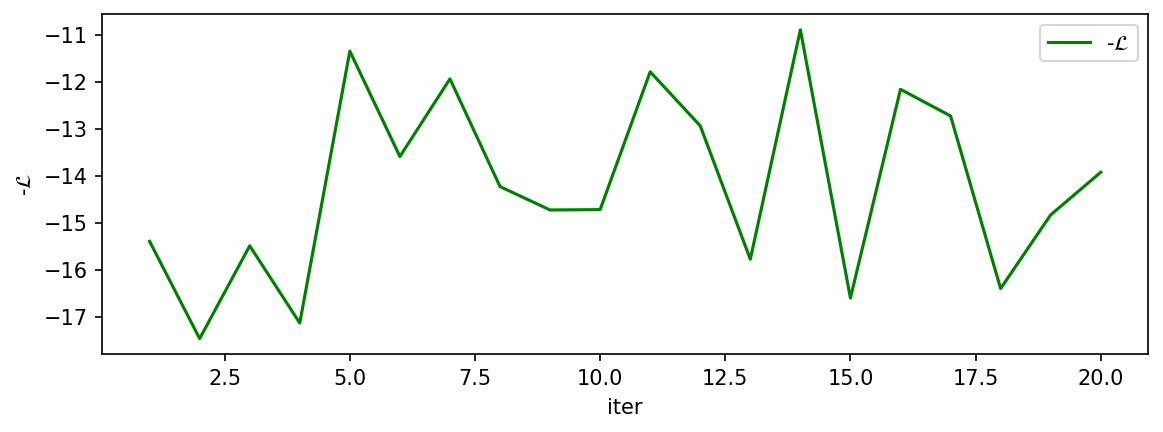

In [424]:
gen = Logic_Model_Generator()
num_sample = 10
data = gen.generate_data(num_sample=num_sample, time_horizon=5)
#print(data)
action_history = {}
for i in range(num_sample):
    action_history_ = dict([(key, data[i][key]) for key in [3,4,5,6]])
    action_history[i] = action_history_
#print(data)
learn = Logic_Model_Incomplete_Data(time_horizon=2,action_history=action_history,hidden_size=(15,10),output_size=(10,4),batch_size=10)
num_iter = 20
losses = learn.train_model(num_iter=num_iter,lr=(0.01,0.1))

X = np.arange(1,num_iter+1,1)
plt.figure(figsize=(9,3),dpi=150)
plt.plot(X, losses, c='green',label='-$\mathcal{L}$')
plt.xlabel('iter')
plt.ylabel('-$\mathcal{L}$')
plt.legend(bbox_to_anchor=(1,1))

print(losses)